In [1]:
import sys, os, pickle, time, json, yaml, re
from glob import glob
sys.path.append('../lib')
sys.path.append('../analysis')
import numpy as np
import pandas as pd
import root_numpy as rtnp
from analysis_utilities import drawOnCMSCanvas, getEff, DSetLoader
from collections import Counter
from prettytable import PrettyTable
import matplotlib.pyplot as plt
from scipy.stats import chi2 as scipy_chi2
from histo_utilities import create_TH1D, make_ratio_plot, create_TH2D, std_color_list

donotdelete = []

Welcome to JupyROOT 6.12/07


In [2]:
import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1


CMS_lumi.extraText = 6*' ' + 'Simulation Internal'

In [3]:
candDir='ntuples_B2DstMu_220114'
skimmedTag='_220117_lostInnerHits_fullM2miss'
MCsample = {
######## Signals
'tau': DSetLoader('Bd_TauNuDst', candDir=candDir, skimmedTag=skimmedTag),
'mu': DSetLoader('Bd_MuNuDst', candDir=candDir, skimmedTag=skimmedTag),
######## D** background
'Bu_MuDstPi': DSetLoader('Bu_MuNuDstPi', candDir=candDir, skimmedTag=skimmedTag),
'Bd_MuDstPi': DSetLoader('Bd_MuNuDstPi', candDir=candDir, skimmedTag=skimmedTag),
# 'Bd_MuDstPiPi': DSetLoader('Bd_MuNuDstPiPi', candDir=candDir, skimmedTag=args.skimmedTag),
'Bd_MuDstPiPi': DSetLoader('Bd_MuNuDstPiPi_v2', candDir=candDir, skimmedTag=skimmedTag),
'Bu_MuDstPiPi': DSetLoader('Bu_MuNuDstPiPi', candDir=candDir, skimmedTag=skimmedTag),
'Bu_TauDstPi': DSetLoader('Bu_TauNuDstPi', candDir=candDir, skimmedTag=skimmedTag),
'Bd_TauDstPi': DSetLoader('Bd_TauNuDstPi', candDir=candDir, skimmedTag=skimmedTag),
'Bd_TauDstPiPi': DSetLoader('Bd_TauNuDstPiPi', candDir=candDir, skimmedTag=skimmedTag),
'Bu_TauDstPiPi': DSetLoader('Bu_TauNuDstPiPi', candDir=candDir, skimmedTag=skimmedTag),
'Bs_MuDstK': DSetLoader('Bs_MuNuDstK', candDir=candDir, skimmedTag=skimmedTag),
'Bs_TauDstK': DSetLoader('Bs_TauNuDstK', candDir=candDir, skimmedTag=skimmedTag),
######## D*Hc background
'Bd_DstDu': DSetLoader('Bd_DstDu', candDir=candDir, skimmedTag=skimmedTag),
'Bu_DstDu': DSetLoader('Bu_DstDu', candDir=candDir, skimmedTag=skimmedTag),
'Bd_DstDd': DSetLoader('Bd_DstDd', candDir=candDir, skimmedTag=skimmedTag),
'Bu_DstDd': DSetLoader('Bu_DstDd', candDir=candDir, skimmedTag=skimmedTag),
'Bd_DstDs': DSetLoader('Bd_DstDs', candDir=candDir, skimmedTag=skimmedTag),
'Bs_DstDs': DSetLoader('Bs_DstDs', candDir=candDir, skimmedTag=skimmedTag),
}

In [4]:
MCsample['mu'].skimmed_dir

'/storage/af/group/rdst_analysis/BPhysics/data/cmsMC/CP_BdToDstarMuNu_SoftQCDnonD_TuneCP5_13TeV-pythia8-evtgen/ntuples_B2DstMu_220114/skimmed_220117_lostInnerHits_fullM2miss'

In [5]:
df = {}
df['mu'] = pd.DataFrame(rtnp.root2array(MCsample['mu'].skimmed_dir + '/High_bare.root'))

In [6]:
weights = pd.DataFrame(rtnp.root2array(
    MCsample['mu'].skimmed_dir + '/weights/High_bare_test_high_CLN_blinded.root'
))

In [7]:
df['mu']['w'] = weights['central']

In [8]:
dataLoc = '/storage/af/group/rdst_analysis/BPhysics/data/cmsRD/'
df['data'] = pd.DataFrame(rtnp.root2array(
    dataLoc+'skimmed_220117_lostInnerHits_fullM2miss/B2DstMu_220113_High_corr.root'))

# Draw plots

In [9]:
binning = {}
binning['q2'] = [0, 3.5, 6, 9.4, 12]

negSide = [-2.5, -1.5, -1.0, -0.6, -0.4, -0.2]
binning['M2_miss'] = [
    negSide + [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 1.5, 4],
    negSide + [0.0, 0.1, 0.2, 0.3] + list(np.arange(0.4, 3.5, 0.2)) + [8],
    negSide + list(np.arange(0, 6, 0.2)) + [8],
    negSide + list(np.arange(0, 7.8, 0.2)) + [8],
]

Innner lost reduction: 85.8%


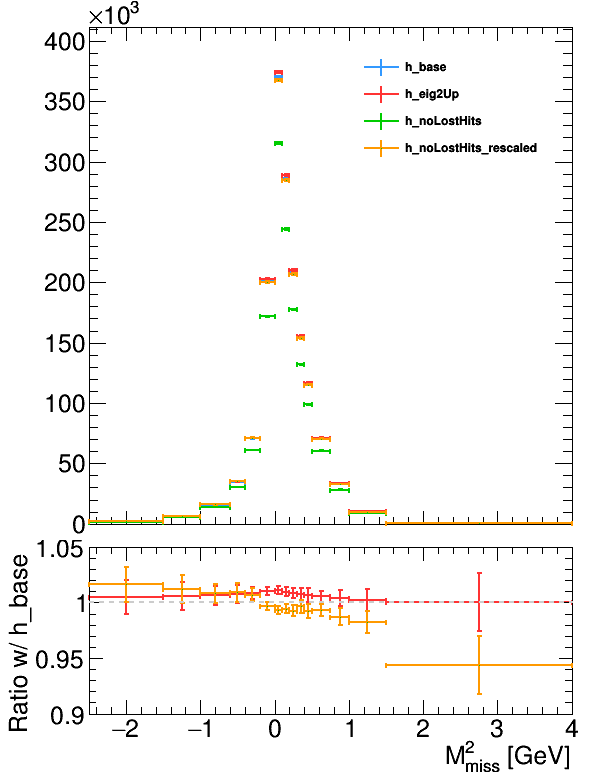

In [10]:
sel = df['mu']['q2'] < 3.5
h_base = create_TH1D(df['mu']['M2_miss'][sel], 'h_base', weights=df['mu']['w'][sel], color=0,
         binning=np.array(binning['M2_miss'][0]), widthNorm=True)

h_eig2Up = create_TH1D(df['mu']['M2_miss'][sel], 'h_eig2Up', weights=weights['B2DstCLNeig2Up'][sel], color=1,
                       binning=h_base.binning, widthNorm=True)

nBefore = np.sum(sel)
for p in ['pis', 'K', 'pi']:
    sel = np.logical_and(sel, df['mu'][p+'_lostInnerHits'] <= 0)
redF = np.sum(sel)/float(nBefore)
print 'Innner lost reduction: {:.1f}%'.format(100*redF)

h_noLostHits = create_TH1D(df['mu']['M2_miss'][sel], 'h_noLostHits', weights=df['mu']['w'][sel], color=2,
                       binning=h_base.binning, widthNorm=True)

h_noLostHits_rescaled = h_noLostHits.Clone('h_noLostHits_rescaled')
h_noLostHits_rescaled.SetTitle(h_noLostHits_rescaled.GetName())
h_noLostHits_rescaled.SetLineColor(std_color_list[3])
h_noLostHits_rescaled.Scale(1./redF)

h_base.SetXTitle('M^{2}_{miss} [GeV]')
c = make_ratio_plot([h_base, h_eig2Up, h_noLostHits, h_noLostHits_rescaled], ratio_bounds=[0.9, 1.05], 
                    leg_pos=[0.6, 0.7, 0.92, 0.9])
c.Draw()
donotdelete.append(c)

In [11]:
h_diff = h_eig2Up.Clone('h_diff')
h_diff.Add(h_base, -1)

s = 0
for i in range(1, h_diff.GetNbinsX()+1):
    s += h_diff.GetBinContent(i)

print s

14273.871036


Innner lost reduction: 81.8%


Warning in <TROOT::Append>: Replacing existing TH1: h_base (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_noLostHits (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratio


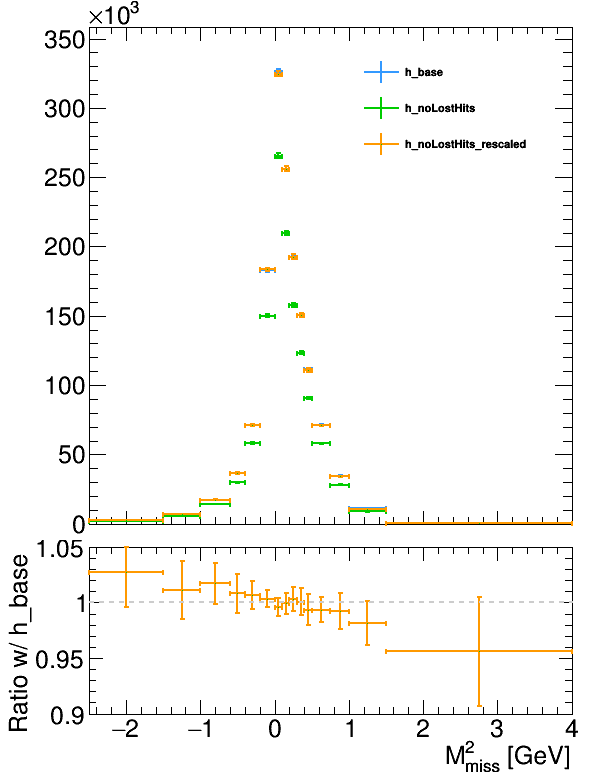

In [12]:
sel = df['data']['q2'] < 3.5
h_base = create_TH1D(df['data']['M2_miss'][sel], 'h_base', color=0,
         binning=np.array(binning['M2_miss'][0]), widthNorm=True)

nBefore = np.sum(sel)
for p in ['pis', 'K', 'pi']:
    sel = np.logical_and(sel, df['data'][p+'_lostInnerHits'] <= 0)
redF = np.sum(sel)/float(nBefore)
print 'Innner lost reduction: {:.1f}%'.format(100*redF)

h_noLostHits = create_TH1D(df['data']['M2_miss'][sel], 'h_noLostHits', color=2,
                       binning=h_base.binning, widthNorm=True)

h_noLostHits_rescaled = h_noLostHits.Clone('h_noLostHits_rescaled')
h_noLostHits_rescaled.SetTitle(h_noLostHits_rescaled.GetName())
h_noLostHits_rescaled.SetLineColor(std_color_list[3])
h_noLostHits_rescaled.Scale(1./redF)

h_base.SetXTitle('M^{2}_{miss} [GeV]')
c = make_ratio_plot([h_base, h_noLostHits, h_noLostHits_rescaled], ratio_bounds=[0.9, 1.05],
                    leg_pos=[0.6, 0.7, 0.92, 0.9])
c.Draw()
donotdelete.append(c)

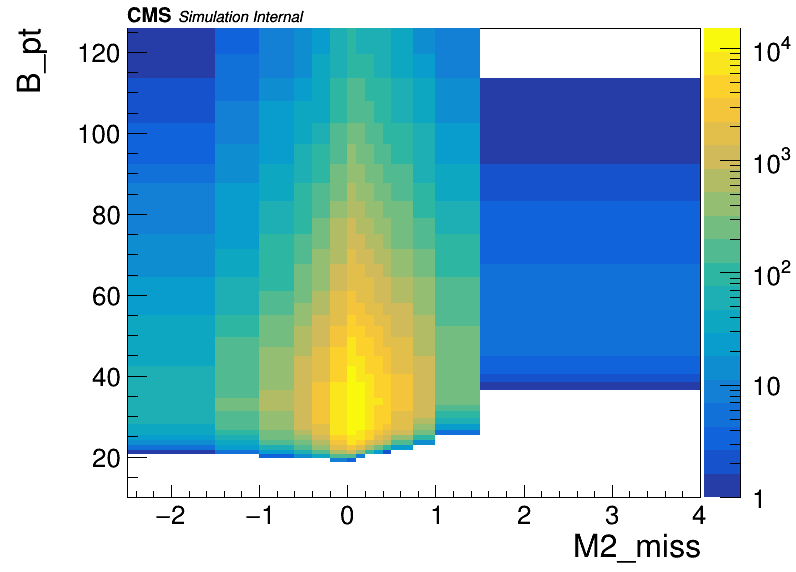

In [13]:
sel = df['mu']['q2'] < 3.5
h_base = create_TH2D(np.array(df['mu'][sel][['M2_miss', 'B_pt']]), 'h2D_base', 
                     weights=df['mu']['w'][sel], axis_title=['M2_miss', 'B_pt', ''],
                     binning=[np.array(binning['M2_miss'][0]),  np.logspace(1, 2.1, 50)])
h_base.Scale(1., 'width')

c = drawOnCMSCanvas(CMS_lumi, [h_base], ['colz'], mR=0.12)
c.SetLogz()
donotdelete.append(c)

In [14]:
sel = np.logical_and(df['mu']['q2'] < 3.5, df['mu']['M2_miss'] > 0.2)
df['mu'][sel][['M2_miss', 'B_pt']].corr()

,M2_miss,B_pt
M2_miss,1.000000,0.196757
B_pt,0.196757,1.000000


# Vertex Density

Warning in <TROOT::Append>: Replacing existing TH1: h_MC_q2b0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_MC_all (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_RD_q2b0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_RD_all (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratio


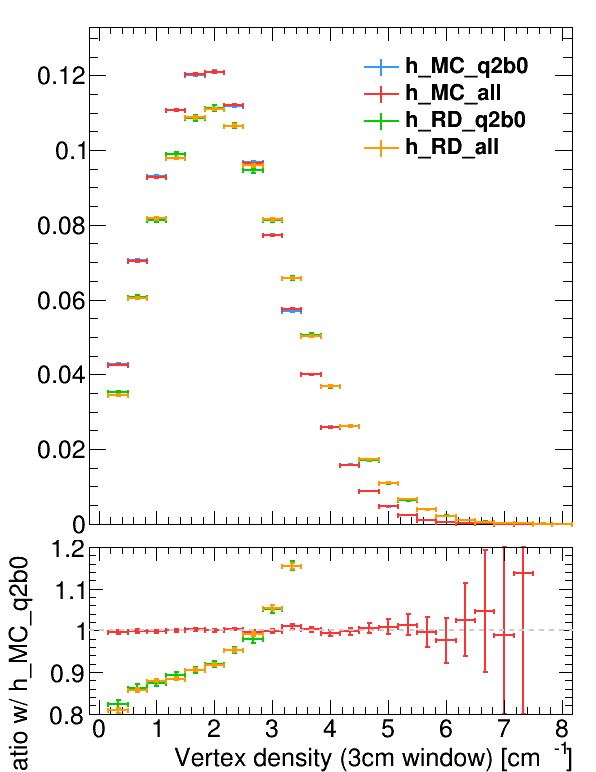

In [24]:
sel = df['mu']['q2'] < 3.5
h_MC_q2b0 = create_TH1D(df['mu']['localVertexDensity'][sel], 'h_MC_q2b0', weights=df['mu']['w'][sel], color=0,
                        binning=np.arange(-0.5, 25.5)/3., scale_histo='norm')

h_MC_all = create_TH1D(df['mu']['localVertexDensity'], 'h_MC_all', weights=df['mu']['w'], color=1,
                       binning=h_MC_q2b0.binning, scale_histo='norm')

sel = df['data']['q2'] < 3.5
h_RD_q2b0 = create_TH1D(df['data']['localVertexDensity'][sel], 'h_RD_q2b0', color=2,
                        binning=h_MC_q2b0.binning, scale_histo='norm')

h_RD_all = create_TH1D(df['data']['localVertexDensity'], 'h_RD_all', color=3,
                       binning=h_MC_q2b0.binning, scale_histo='norm')

h_MC_q2b0.SetXTitle('Vertex density (3cm window) [cm^{-1}]')
c = make_ratio_plot([h_MC_q2b0, h_MC_all, h_RD_q2b0, h_RD_all], ratio_bounds=[0.8, 1.2], 
                    leg_pos=[0.6, 0.7, 0.92, 0.9])
c.Draw()
donotdelete.append(c)

Warning in <TROOT::Append>: Replacing existing TH1: h_MC (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


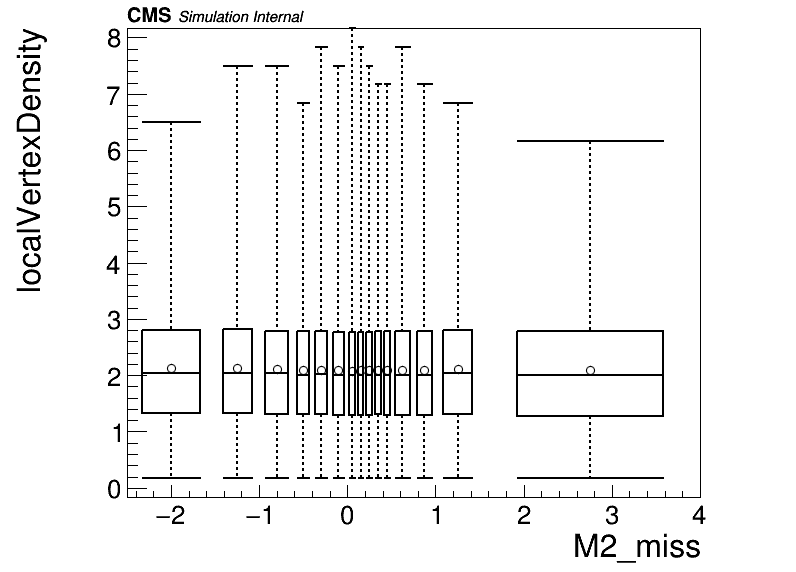

In [25]:
sel = df['mu']['q2'] < 3.5
h_MC = create_TH2D(np.array(df['mu'][sel][['M2_miss', 'localVertexDensity']]), 'h_MC', 
                     weights=df['mu']['w'][sel], axis_title=['M2_miss', 'localVertexDensity', ''],
                     binning=[np.array(binning['M2_miss'][0]),  np.arange(-0.5, 25.5)/3.])
h_MC.Scale(1., 'width')

c = drawOnCMSCanvas(CMS_lumi, [h_MC], ['candlex'], mR=0.12)
# c.SetLogz()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


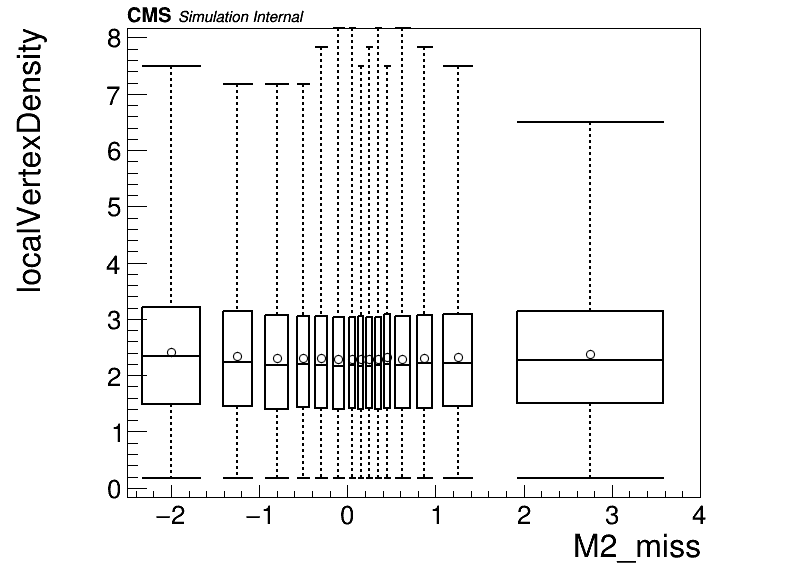

In [26]:
sel = df['data']['q2'] < 3.5
h_RD = create_TH2D(np.array(df['data'][sel][['M2_miss', 'localVertexDensity']]), 'h_RD', 
                     axis_title=['M2_miss', 'localVertexDensity', ''],
                     binning=[np.array(binning['M2_miss'][0]),  np.arange(-0.5, 25.5)/3.])
h_RD.Scale(1., 'width')

c = drawOnCMSCanvas(CMS_lumi, [h_RD], ['candlex'], mR=0.12)
# c.SetLogz()

Warning in <Sumw2>: Sum of squares of profile bin weights structure already created
Warning in <Sumw2>: Sum of squares of profile bin weights structure already created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


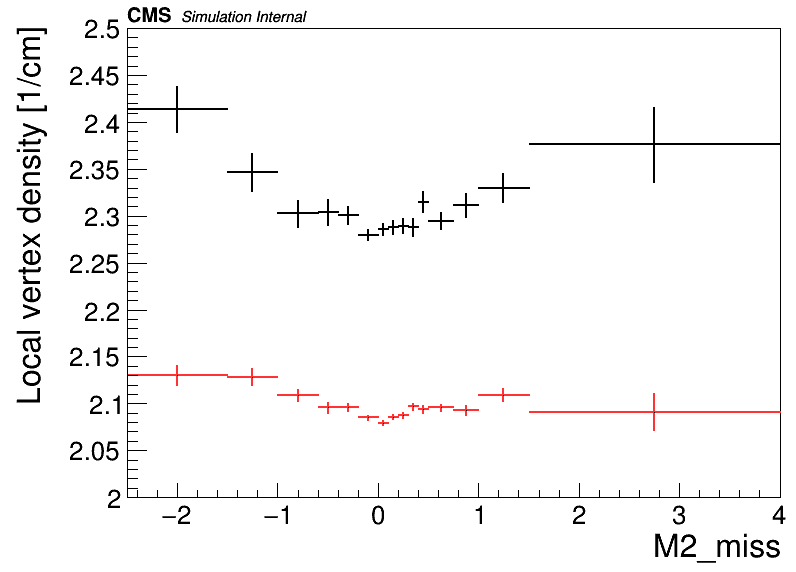

In [34]:
hp_MC = h_MC.ProfileX()
hp_MC.SetLineColor(std_color_list[1])
hp_RD = h_RD.ProfileX()

hp_MC.GetYaxis().SetRangeUser(2.0, 2.5)
hp_MC.GetYaxis().SetTitle('Local vertex density [1/cm]')
c = drawOnCMSCanvas(CMS_lumi, [hp_MC, hp_RD], ['', 'same'])